Contents:

1. Importing libraries and dataset
2. Creating functions
3. Exclusion criteria
4. Brief exploratory data analysis
5. Prepare training dataset
6. Prepare testing dataset
7. Hyperparameter optimisations
8. Evaluation of KNN model
9. Benchmarking
10. Retrieve neighbours for products in testing dataset
11. Performance by first neighbour distance
12. Performance by training dataset size

# 1. Importing libaries and dataset

In [1]:
# Import KNN framework from sklearn
from sklearn.neighbors import KNeighborsRegressor

# Import libraries for statistical analysis
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report
from scipy.stats import spearmanr
import numpy as np

# Import library for data manipulation
import pandas as pd
pd.set_option('display.max_columns', None)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Filter all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import training dataset
train = pd.read_csv('export (1).txt', delimiter="\t", encoding='latin1')

# Import dataset that maps training dataset categories to category system used in analysis
cats2 = pd.read_excel('cats_map2 (2).xlsx')

# Important testing dataset
test = pd.read_excel('LP_mock_dataset_12.11.2020-2 的複本-JIMMY-IDEACENTER (1) TD.xlsx', sheet_name = 'Clean')

# Import predicted AS values using JL method for testing dataset
JL = pd.read_excel('JL_method (1).xlsm')[['Product Id', 'JLAS_g']]

# Check out training dataset
train.tail(3)

,UPC,Brand,Description,Product Category,Size,Date Collected,Flavor,Ingredients,Serve Description,Serving Size,Serving Size 2,Serving Size UOM,Serving Size UOM 2,Size 2,Added Sugars Per 100,Added Sugars UOM,Calories Per 100,Calories UOM,Dietary Fiber Per 100,Dietary Fiber UOM,Protein Per 100,Protein UOM,Saturated Fat Per 100,Saturated Fat UOM,Sodium Per 100,Sodium UOM,Sugars Per 100,Sugars UOM,Total Carbohydrate Per 100,Total Carbohydrate UOM,Total Fat Per 100,Total Fat UOM,Total Sugars Per 100,Total Sugars UOM
599837,50000032631,NESTLE,RICH CHOCOLATE FLAVOR HOT COCOA MIX,Powdered Drink - Instant Cocoa & Flavored or M...,0.71 oz,"Fri Jul 06, 2012",RICH CHOCOLATE,"SUGAR, CORN SYRUP SOLIDS, VEGETABLE OIL (PARTI...",1 ENVELOPE,20,NaN,g,NaN,20.2 g,NaN,NaN,400.00,Cal,2.50,g,2.50,g,10.00,g,850.00,mg,60.00,g,75.00,g,15.00,g,NaN,NaN
599838,835228011015,BAKERY ON MAIN,CRANBERRY MAPLE NUT GRANOLA BARS,Bars - Granola Bars,6 oz,"Tue Jul 03, 2012",NaN,"RICE SYRUP, CRISP RICE (RICE FLOUR, RICE BRAN,...",1 BAR,34,NaN,g,NaN,170 g,NaN,NaN,500.00,Cal,5.88,g,8.82,g,1.47,g,250.00,mg,32.35,g,88.24,g,14.71,g,NaN,NaN
599839,77901010018,PRESIDENT,PASTEURIZED PROCESS CHEESE SPREAD,Cheese - Spreadable Cheese,8 oz,"Wed Aug 29, 2012",NaN,"BRIE, CHEDDAR AND MOZZARELLA, NISAPLIN, MILK P...",(ABOUT 1 WEDGE),1,28,oz,g,227 g,NaN,NaN,285.71,Cal,NaN,NaN,17.86,g,14.29,g,892.86,mg,0.00,g,1.79,g,25.00,g,NaN,NaN


# 2. Creating functions

In [3]:
# This function determines if a product is a food or drink based on the unit in the "Size" field
drink_units = ['gal', 'pt', 'gallon', 'floz', 'pint', 'l', 'ml', 'fl.oz', 'liter', 'liters', 'fl oz', 'quart']

def food_or_drink(string):
    # Isolate product size unit
    unit = ' '.join(string.split(' ')[1:])
    if unit in drink_units:
        return 'Drink'
    else:
        return 'Food'

In [4]:
# This classifies products as low, medium or high in added sugar. Cut-offs are different for foods and drinks
def high_medium_low(string):
    food_or_drink = string.split(' ')[0]
    AS = float(string.split(' ')[-1])
    if food_or_drink == "Drink":
        if AS < 1.25:
            return 'Low'
        elif AS <= 5.625:
            return 'Medium'
        else:
            return 'High'
    else:
        if AS < 2.5:
            return 'Low'
        elif AS <= 11.25:
            return 'Medium'
        else:
            return 'High'


In [5]:
# This identifies products that contain an added sugar ingredient
AS_ings = ['glucose', 'fructose', ' dextrose', 'sucrose', 'sugar',
          'lactose', 'maltose', 'syrup', 'molasses',
          'honey', 'fruit concentrate', 'chocolate']

def contains_AS(string):
    try:
        AS = 0      
        for AS_ing in AS_ings:
            if AS_ing in string.lower():
                AS +=1
                break
        return AS
        
    except:
        return np.NaN

In [6]:
# This function simply maps minor categories to major categories
def major(string):
    if string in ['Bread', 'Biscuits',  'Cakes, muffins and pastries']:
        return 'Bread and bakery items'
    elif string in ['Breakfast cereals',  'Bars', 'Noodles','Other cereal and grain',
                      'Pasta','Rice']:
        return 'Cereals and cereal-grain products'
    elif string in ['Chocolate','Sugar-based confectionery']:
        return 'Confectionery'
    elif string in ['Ready meals','Pizza', 'Soup']:
        return 'Convenience foods'
    elif string in ['Cheese','Cream', 'Milk','Yoghurt', 'Ice cream', 'Desserts']:
        return 'Dairy products'
    elif string in ['Fruit', 'Herbs and spices','Nuts and seeds', 'Vegetables']:
        return 'Fruit and vegetables'
    elif string in ['Processed meat', 'Meat alternatives']:
        return 'Meat and alternatives'
    elif string in ['Fish']:
        return 'Seafood and seafood products'
    elif string in ['Hot drinks', 'Juice', 'Other sweetened drinks','Soft drinks', 'Waters']:
        return 'Non-alcoholic beverages'
    elif string in ['Sauces', 'Mayonnaise and salad dressings', 'Spreads and dips']:
        return 'Sauces, dips and salad dressings'
    elif string in ['Crisps', 'Other savory snacks', 'Snacks']:
        return 'Snack foods'
    elif string in ['Special foods']:
        return 'Special foods'
    elif string in ['Sugars, honey and related']:
        return 'Sugars, honey and related'
    else:
        return np.NaN

In [7]:
# Create a function that determines the spearman correlation between two lists, using scipy.stats spearmanr
def spearman_correlation(list1,list2):
    return spearmanr(list1, list2)[0]

# 3. Exclusion criteria

In [8]:
# Quick clean up first

# Condense sugar columns
c1 = (train['Total Sugars Per 100'].isnull())
train['Total Sugars Per 100'] = np.where(c1, train['Sugars Per 100'], train['Total Sugars Per 100'])

# Condense sugar units
c2 = (train['Total Sugars UOM'].isnull())
train['Total Sugars UOM'] = np.where(c2, train['Sugars UOM'], train['Total Sugars UOM'])

# Drop unwanted columns
train.drop(columns = ['Sugars UOM', 'Sugars Per 100','Flavor', 'Serve Description',
       'Serving Size', 'Serving Size 2', 'Serving Size UOM',
       'Serving Size UOM 2', 'Calories UOM', 'Calories Per 100'], inplace=True)

# Merge on minor categories (KNN categories) from "cats" dataframe
train['Condensed category'] = train['Product Category'].str.split('-').str[0].str.lstrip().str.rstrip()
train =train.merge(cats2[['Condensed category', 'KNN category']],
        on = 'Condensed category', how = 'left')

# Quick correction - any product category with "Sauce" in name is "Sauce"
c3 = train['Product Category'].str.contains('Sauce')
train['KNN category'] = np.where(c3, 'Sauces', train['KNN category'])

In [9]:
print('n:', train.shape[0])


# Drop barcode duplicates
train = train.drop_duplicates(subset = 'UPC')
print('n after dropping UPC duplicates:', train.shape[0])


# Drop products outside of the analysed minor categories
train = train[~train['KNN category'].isnull()]
print('n after dropping excluded categories:', train.shape[0])

# Drop products without nutrition information panels - find by the absence of useable unit information for each nutrient
for col in ['Added Sugars UOM', 'Dietary Fiber UOM', 'Protein UOM', 'Saturated Fat UOM',
           'Sodium UOM', 'Total Carbohydrate UOM', 'Total Fat UOM',
           'Total Sugars UOM']:
    train[col] = train[col].str.replace('\n', '').str.lstrip().str.rstrip()

train = train[train['Total Carbohydrate UOM'] == "g"]
train = train[train['Total Sugars UOM'] == "g"]
train = train[train['Added Sugars UOM'] == "g"]
train = train[train['Protein UOM'] == "g"]
train = train[train['Total Fat UOM'] == "g"]
train = train[train['Saturated Fat UOM'] == "g"]
train = train[train['Sodium UOM'] == "mg"]
train = train[train['Dietary Fiber UOM'] == "g"]
train = train.dropna()
print('n after dropping products without nutrition information panels:', train.shape[0])





# Drop products prior to 2017
train = train[train['Date Collected'].str.split(',').str[-1].astype(int)>=2017]
print('n after 2017 cut-off', train.shape[0])

n: 599840
n after dropping UPC duplicates: 599803
n after dropping excluded categories: 399525
n after dropping products without nutrition information panels: 64764
n after 2017 cut-off 64502


In [10]:
# Drop products with infeasible nutrient values, e.g. nutrient value greater than 100g per 100g.
train = train[train['Dietary Fiber Per 100']<=100]
train = train[train['Protein Per 100']<=100]
train = train[train['Saturated Fat Per 100']<=100]
train = train[train['Total Carbohydrate Per 100']<=100]
train = train[train['Total Fat Per 100']<=100]
train = train[train['Total Sugars Per 100']<=100]
train = train[train['Added Sugars Per 100']<=100]
train = train[train['Sodium Per 100']<=42400]
train = train[train['Added Sugars Per 100']<=train['Total Sugars Per 100']]
train = train[train['Total Sugars Per 100']<=train['Total Carbohydrate Per 100']]
train = train[train['Saturated Fat Per 100']<=train['Total Fat Per 100']]
train = train[train['Dietary Fiber Per 100']<=train['Total Carbohydrate Per 100']]
train['Starch Per 100'] = train['Total Carbohydrate Per 100'] - train['Total Sugars Per 100'] - train['Dietary Fiber Per 100']
train = train[train['Starch Per 100']>=0]

# Drop products that report zero added sugar but that have an added sugar ingredient listed first in the ingredients statement
c4 = train['Ingredients'].str.replace('SUGAR SNAP', '').str.split(',').str[0].apply(contains_AS)==1
c5 = train['Added Sugars Per 100'] == 0
train = train[~(c4&c5)]

# Drop products that report 100% total sugar but 0% natural sugar - impossible
c6 = train['Total Sugars Per 100'] == 100
c7 = train['Added Sugars Per 100'] == 0
train = train[~(c6&c7)]

print('n after dropping unclean products:', train.shape[0])


# Drop pack size duplicates (i.e. same product, different pack size) - find by duplication of name, ingredient and nutrient info
train['all'] = train['Description'].str.lower().str.lstrip().str.rstrip() + train['Ingredients'].str.lower().str.rstrip().str.lstrip() + train['Added Sugars Per 100'].astype(str) + train['Total Carbohydrate Per 100'].astype(str) + train['Total Fat Per 100'].astype(str) + train['Saturated Fat Per 100'].astype(str) + train['Protein Per 100'].astype(str) + train['Total Sugars Per 100'].astype(str) + train['Dietary Fiber Per 100'].astype(str) + train['Sodium Per 100'].astype(str)
train.drop_duplicates(subset = 'all', inplace=True)
print('n after dropping pack size duplicates:', train.shape[0])


# Drop products with zero sugar - don't require added sugar estimation
train = train[train['Total Sugars Per 100'] > 0]
train.shape[0]
print('n after dropping products without sugar:', train.shape[0])

train.reset_index(drop=True, inplace=True)

n after dropping unclean products: 62712
n after dropping pack size duplicates: 56830
n after dropping products without sugar: 46990


In [11]:
# round all nutrient values to one decimal place
for col in ['Dietary Fiber Per 100',
           'Protein Per 100',
           'Saturated Fat Per 100',
           'Total Carbohydrate Per 100',
           'Total Fat Per 100',
           'Total Sugars Per 100',
           'Added Sugars Per 100',
           'Sodium Per 100']:
    train[col] = np.round(train[col], 1)

# map all minor (KNN) categories to major categories
train['Major category'] = train['KNN category'].apply(major)


# 4. Brief exploratory data analysis

In [12]:
# Construct new nutrient features
train['Starch Per 100'] = train['Total Carbohydrate Per 100'] - train['Total Sugars Per 100'] - train['Dietary Fiber Per 100']
train['Unsaturated Fat Per 100'] = train['Total Fat Per 100'] - train['Saturated Fat Per 100']

# Construct binary feature for the presence/absence of an added sugar ingredient
train['AS ingredient'] = train['Ingredients'].str.lower().apply(contains_AS)

In [13]:
# Explore the distributions of the six nutrients
np.round(train[['Total Sugars Per 100', 
             'Starch Per 100', 
             'Saturated Fat Per 100', 
             'Unsaturated Fat Per 100', 
             'Protein Per 100', 
             'Sodium Per 100',
             'Added Sugars Per 100']].describe(), 1)

,Total Sugars Per 100,Starch Per 100,Saturated Fat Per 100,Unsaturated Fat Per 100,Protein Per 100,Sodium Per 100,Added Sugars Per 100
count,46990.0,46990.0,46990.0,46990.0,46990.0,46990.0,46990.0
mean,17.3,19.6,4.0,7.9,6.7,348.6,13.4
std,19.0,19.2,5.6,10.5,6.5,572.5,18.4
min,0.0,-0.1,0.0,0.0,0.0,0.0,0.0
25%,3.4,3.3,0.0,0.8,2.4,56.8,0.0
50%,8.1,12.9,1.8,4.0,5.0,258.6,3.6
75%,26.7,32.4,6.4,10.7,9.2,459.0,21.9
max,100.0,90.9,62.3,71.6,73.7,21100.0,100.0


In [14]:
# Explore the spearman correlations between each nutrient and AS content
np.round(train[['Total Sugars Per 100', 
             'Starch Per 100', 
             'Saturated Fat Per 100', 
             'Unsaturated Fat Per 100', 
             'Protein Per 100', 
             'Sodium Per 100',
             'Added Sugars Per 100']].corr(method='spearman')['Added Sugars Per 100'], 2)

Total Sugars Per 100       0.83
Starch Per 100             0.13
Saturated Fat Per 100      0.33
Unsaturated Fat Per 100    0.19
Protein Per 100           -0.15
Sodium Per 100            -0.00
Added Sugars Per 100       1.00
Name: Added Sugars Per 100, dtype: float64

In [15]:
# Analyse added sugar content by category
data = []
for cat in train['Major category'].value_counts().index.tolist():
    subset = train[train['Major category'] == cat]
    row = subset['Added Sugars Per 100'].describe().to_dict()
    row['Major category'] = cat
    data.append(row)
    
row = train['Added Sugars Per 100'].describe().to_dict()
row['Major category'] = '_Total'
data.append(row)

table1 = pd.DataFrame(data)[['Major category', 'count', 'std', 'min',
                           'mean','25%', '50%', '75%', 'max']]

# Round values
table1['count'] = table1['count'].astype(int)
table1['std'] = np.round(table1['std'], 1)
table1['mean'] = np.round(table1['mean'], 1)
table1['75%'] = np.round(table1['75%'], 1)
table1.sort_values(by = 'Major category')

,Major category,count,std,min,mean,25%,50%,75%,max
0,Bread and bakery items,8776,15.4,0.0,19.6,4.9,18.65,33.3,73.9
3,Cereals and cereal-grain products,5249,13.5,0.0,11.9,0.0,6.70,21.9,55.8
6,Confectionery,3258,16.8,0.0,50.4,41.2,48.35,60.0,100.0
4,Convenience foods,4348,2.6,0.0,1.4,0.0,0.40,1.5,37.5
2,Dairy products,6023,14.3,0.0,12.8,0.0,12.10,18.3,100.0
1,Fruit and vegetables,8338,12.9,0.0,6.0,0.0,0.00,3.6,99.0
10,Meat and alternatives,648,2.6,0.0,1.7,0.0,1.20,1.8,19.3
8,Non-alcoholic beverages,2451,20.9,0.0,10.4,0.0,0.00,9.6,100.0
7,"Sauces, dips and salad dressings",2725,12.7,0.0,7.8,0.0,2.40,8.8,88.9
11,Seafood and seafood products,307,4.1,0.0,2.1,0.0,1.00,2.4,42.9


# 5. Prepare training dataset

In [16]:
# Create a dataframe for normalised nutrients
normalised_nutrients = train[[
        'Protein Per 100', 
        'Saturated Fat Per 100',
       'Sodium Per 100',
        'Unsaturated Fat Per 100',
       'Total Sugars Per 100',
        'Starch Per 100',    
       ]]
for col in [
        'Protein Per 100', 
        'Saturated Fat Per 100',
       'Sodium Per 100',
        'Unsaturated Fat Per 100',
         'Total Sugars Per 100',
        'Starch Per 100']:
    normalised_nutrients[col] = normalised_nutrients[col]/train[col].max()

# Create a dataframe for the presence/absence of an added sugar ingredient
AS_ingredient = train[['AS ingredient']]
        
# Create a dataframe for dummy-coded food categories
dummy_categories = pd.get_dummies(train['KNN category'], drop_first = True).reset_index(drop=True)

# Create a dataframe for food or drink
F_OR_D = pd.DataFrame(train['Size'].apply(food_or_drink))
F_OR_D.columns = ['Food/drink']

# Create a dataframe for the target
target = train[['Added Sugars Per 100']]

# Combine these four dataframes
train_prep = pd.concat([normalised_nutrients, AS_ingredient, dummy_categories, F_OR_D, target], axis=1)

In [17]:
# Create a table of brand names 
brand_table = pd.DataFrame()
brand_table['Brand'] = train['Brand'].value_counts().index.tolist()
brand_table['Count'] = train['Brand'].value_counts().tolist()
brand_table.sort_values(by = ['Count', 'Brand'], ascending = [False, False], inplace=True)

# Divide brands into 5 groups, these will be the 5 groups used for cross-validation
brand_table['Group'] = brand_table.index%5

brand_table.head(10)

,Brand,Count,Group
0,SIGNATURE SELECT,1075,0
1,WEGMANS,914,1
2,MEIJER,815,2
3,GREAT VALUE,782,3
4,ESSENTIAL EVERYDAY,708,4
5,GOOD & GATHER,631,0
6,NOT A BRANDED ITEM,626,1
7,FOOD CLUB,619,2
8,HARRIS TEETER,500,3
9,HY-VEE,495,4


In [18]:
# create a list of brand names for each group
brands_1 = brand_table[brand_table['Group']==0]['Brand'].unique().tolist()
brands_2 = brand_table[brand_table['Group']==1]['Brand'].unique().tolist()
brands_3 = brand_table[brand_table['Group']==2]['Brand'].unique().tolist()
brands_4 = brand_table[brand_table['Group']==3]['Brand'].unique().tolist()
brands_5 = brand_table[brand_table['Group']==4]['Brand'].unique().tolist()

# 6. Prepare testing dataset

In [19]:
# testing dataset doesn't have "Size" column - determine food/drink by mapping food categories
liquids = ['sauces', 'milk', 'juice', 'waters', 'other sweetened drinks', 'mayonnaise and salad dressings','soft drinks', 'soup', 'hot drinks']
test['Food/drink'] = np.where(test['KNN category'].isin(liquids), 'Drink', 'Food')

# Clean up KNN category
test['KNN category'] = test['KNN category'].str.lstrip().str.rstrip()
test['KNN category'] = test['KNN category'].str.replace('OTHER CEREAL AND GRAIN PRODUCTS', 'OTHER CEREAL AND GRAIN')
test['KNN category'] = test['KNN category'].str.lower()

# Create a dataframe for the presence/absence of an added sugar ingredient
test['AS ingredient'] = test['Ingredients'].apply(contains_AS)

# Map KNN categories to major categories
test['Major category'] = test['KNN category'].str.capitalize().apply(major)

In [20]:
# Create a dataframe for normalised nutrients
normalised_nutrients_2 = test[[
        'Protein Per 100', 
        'Saturated Fat Per 100',
       'Sodium Per 100',
        'Unsaturated Fat Per 100',
       'Total Sugars Per 100',
        'Starch Per 100',    
       ]]

for col in [
        'Protein Per 100', 
        'Saturated Fat Per 100',
       'Sodium Per 100',
        'Unsaturated Fat Per 100',
         'Total Sugars Per 100',
        'Starch Per 100']:
    normalised_nutrients_2[col] = normalised_nutrients_2[col]/train[col].max()

# Create a dataframe for the presence/absence of an added sugar ingredient
AS_ingredient_2 = test[['AS ingredient']]
        
# Create a dataframe for dummy-coded food categories
dummy_categories_2 = pd.get_dummies(test['KNN category'], drop_first = True).reset_index(drop=True)

# Create a dataframe for food or drink
F_OR_D_2 = pd.DataFrame(test['Food/drink'])

# Create a dataframe for the target
target_2 = test[['Added Sugars Per 100']]

# Combine these four dataframes
test_prep = pd.concat([normalised_nutrients_2, AS_ingredient_2, dummy_categories_2, F_OR_D_2, target_2], axis=1)

In [21]:
test_prep.shape

(500, 47)

# 7. Hyperparameter optimisation

In [22]:
# The 5-fold cross-validation performance metrics for each hyperparameter combination will be appended here.
data = []

# Loop through numbers of neighbours.
for n in [1, 3, 5, 8, 10]:
    
    # Loop through weight functions.
    for w in ['distance', 'uniform']:
        
        # Loop through distance metrics.
        for m in ['euclidean', 'manhattan']:
            
            # Initiate the KNN algorithm using the given hyperparameters.
            KNN = KNeighborsRegressor(n_neighbors = n, weights = w, metric = m)
            
            # Create an empty dictionary. Append hyperparameter information here first
            row = {}
            row['Neighbours'] = n
            row['Weight'] = w
            row['Metric'] = m
            
            # Perform cross validation
            data2 = []
            for validation_brands in [brands_1, brands_2, brands_3, brands_4, brands_5]:
                
                # Construct dataframe for input features of training brands
                X_train = train_prep[~train['Brand'].isin(validation_brands)]
                X_train = X_train[X_train.columns[:-2]]

                # Construct dataframe for AS values of training brands
                y_train = train_prep[~train['Brand'].isin(validation_brands)]
                y_train = y_train[y_train.columns[-1]]                
                
                # Construct dataframe for input features of validation brands
                X_val = train_prep[train['Brand'].isin(validation_brands)]
                X_val = X_val[X_val.columns[:-2]]
                
                # Construct dataframe for AS values of validation brands
                y_val = train_prep[train['Brand'].isin(validation_brands)]
                y_val = y_val[y_val.columns[-1]]
               
                # train model
                model = KNN.fit(X_train, y_train)
                
                # Apply model
                y_pred = model.predict(X_val)
                
                # Make sure all predictions are smaller than the total sugar value
                total_sugar = X_val['Total Sugars Per 100']*train['Total Sugars Per 100'].max()
                y_pred = np.where(y_pred>total_sugar, total_sugar, y_pred)
                
                # Obtain performance metrics for each iteration
                row2 = {}
                row2['R2'] = r2_score(y_val, y_pred)
                row2['MAE'] = mean_absolute_error(y_val, y_pred)
                row2['SRC'] = spearman_correlation(y_val, y_pred)               
                predicted_classes = (train_prep[train['Brand'].isin(validation_brands)]['Food/drink'] + ' ' + y_pred.astype(str)).apply(high_medium_low)
                true_classes = (train_prep[train['Brand'].isin(validation_brands)]['Food/drink'] + ' ' + y_val.astype(str)).apply(high_medium_low)                
                row2['CA'] = accuracy_score(predicted_classes, true_classes)
                data2.append(row2)          
            
            # Obtain the average across all validation folds
            metrics = pd.DataFrame(data2)
            row['R2'] = np.round(metrics['R2'].mean(), 2)
            row['MAE'] = np.round(metrics['MAE'].mean(), 2)
            row['SRC'] = np.round(metrics['SRC'].mean(), 2)
            row['CA'] = np.round(metrics['CA'].mean(), 2)
            data.append(row)
            
HPT = pd.DataFrame(data)
HPT[['Metric', 'Neighbours', 'Weight', 'R2', 'MAE', 'SRC', 'CA']]

,Metric,Neighbours,Weight,R2,MAE,SRC,CA
0,euclidean,1,distance,0.95,1.56,0.94,0.92
1,manhattan,1,distance,0.95,1.53,0.94,0.92
2,euclidean,1,uniform,0.95,1.56,0.94,0.92
3,manhattan,1,uniform,0.95,1.53,0.94,0.92
4,euclidean,3,distance,0.96,1.42,0.95,0.92
5,manhattan,3,distance,0.96,1.42,0.95,0.92
6,euclidean,3,uniform,0.96,1.50,0.95,0.92
7,manhattan,3,uniform,0.96,1.50,0.95,0.92
8,euclidean,5,distance,0.96,1.39,0.95,0.93
9,manhattan,5,distance,0.96,1.38,0.96,0.93


In [23]:
# Construct the model on all training data using the ideal hyperparameters
KNN = KNeighborsRegressor(n_neighbors = 8, weights = 'distance', metric = 'manhattan')
X = train_prep[train_prep.columns[:-2]]
y = train_prep[train_prep.columns[-1]]
model = KNN.fit(X, y)

# 8. Evaluation of KNN model

In [24]:
test['Predicted AS'] = model.predict(test_prep[test_prep.columns[:-2]])
test['Predicted AS'] = np.where(test['Predicted AS'] > test['Total Sugars Per 100'], test['Total Sugars Per 100'], test['Predicted AS'])

test['Predicted AS class'] = (test['Food/drink'] + ' ' + test['Predicted AS'].astype(str)).apply(high_medium_low)
test['True AS class'] = (test['Food/drink'] + ' ' + test['Added Sugars Per 100'].astype(str)).apply(high_medium_low)


In [25]:
data3 = []

# Explore the performance across all test products
row = {}
row['Major category'] = '_All categories'
row['n']= test.shape[0]    

row['Added Sugars Per 100 mean'] = np.round(test['Added Sugars Per 100'].mean(), 1)
row['Added Sugars Per 100 SD'] = np.round(test['Added Sugars Per 100'].std(), 1)

row['Predicted AS mean'] = np.round(test['Predicted AS'].mean(), 1)
row['Predicted AS SD'] = np.round(test['Predicted AS'].std(), 1)

row['R2'] = np.round(r2_score(test['Added Sugars Per 100'], test['Predicted AS']), 2)
row['MAE'] = np.round(mean_absolute_error(test['Added Sugars Per 100'], test['Predicted AS']), 2)
row['SRC'] = np.round(spearman_correlation(test['Added Sugars Per 100'], test['Predicted AS']), 2)
row['CA'] = np.round(accuracy_score(test['Predicted AS class'], test['True AS class']), 2)
data3.append(row)

# Explore the performance across Minor food categories
Minor_cats = test['Major category'].value_counts().index.tolist()
for Minor_cat in Minor_cats:
    subset = test[test['Major category'] == Minor_cat]
    row = {}
    row['Major category'] = Minor_cat
    row['n']= subset.shape[0]    
    
    row['Added Sugars Per 100 mean'] = np.round(subset['Added Sugars Per 100'].mean(), 1)
    row['Added Sugars Per 100 SD'] = np.round(subset['Added Sugars Per 100'].std(), 1)

    row['Predicted AS mean'] = np.round(subset['Predicted AS'].mean(), 1)
    row['Predicted AS SD'] = np.round(subset['Predicted AS'].std(), 1)
   
    row['R2'] = np.round(r2_score(subset['Added Sugars Per 100'], subset['Predicted AS']), 2)
    row['MAE'] = np.round(mean_absolute_error(subset['Added Sugars Per 100'], subset['Predicted AS']), 2)
    row['SRC'] = np.round(spearman_correlation(subset['Added Sugars Per 100'], subset['Predicted AS']), 2)     
    row['CA'] = np.round(accuracy_score(subset['True AS class'], subset['Predicted AS class']), 2)
    data3.append(row)

KNN_performance = pd.DataFrame(data3)
KNN_performance.sort_values(by = 'Major category')[['Major category','n',
                                                    'Added Sugars Per 100 mean','Added Sugars Per 100 SD',
                                                    'Predicted AS mean', 'Predicted AS SD','R2','MAE','SRC','CA']]

,Major category,n,Added Sugars Per 100 mean,Added Sugars Per 100 SD,Predicted AS mean,Predicted AS SD,R2,MAE,SRC,CA
2,Bread and bakery items,64,15.6,17.3,16.4,15.5,0.80,3.43,0.97,0.84
5,Cereals and cereal-grain products,48,4.7,8.4,5.0,8.1,0.83,1.68,0.87,0.85
9,Confectionery,33,41.5,21.5,40.5,20.6,0.96,2.80,0.97,0.97
6,Convenience foods,43,1.9,2.4,1.3,1.4,0.68,0.94,0.82,0.91
1,Dairy products,68,5.9,12.2,5.7,11.4,0.96,1.04,0.97,0.91
4,Fruit and vegetables,59,6.5,15.4,5.1,11.7,0.91,1.69,0.78,0.93
8,Meat and alternatives,37,0.8,1.3,0.9,1.3,0.90,0.28,0.78,1.00
7,Non-alcoholic beverages,37,9.1,14.4,9.3,15.9,0.85,2.17,0.97,0.95
3,"Sauces, dips and salad dressings",60,13.0,18.1,11.9,16.8,0.96,2.14,0.94,0.78
11,Seafood and seafood products,15,0.7,0.9,0.7,0.9,0.53,0.39,0.85,1.00


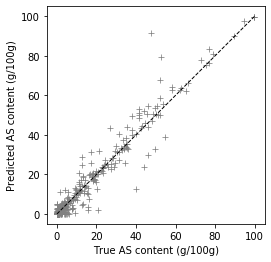

In [38]:
# Scatter plot
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('scaled')
g = sns.scatterplot(color = 'grey',x = 'Predicted AS', y = 'Added Sugars Per 100', data = test, marker = '+')
plt.plot([0, 100], [0, 100], 'black', linewidth = 1, linestyle = "--");
plt.xlabel('True AS content (g/100g)')
plt.ylabel('Predicted AS content (g/100g)');
g.get_figure().savefig('AS plot.png', dpi = 400)

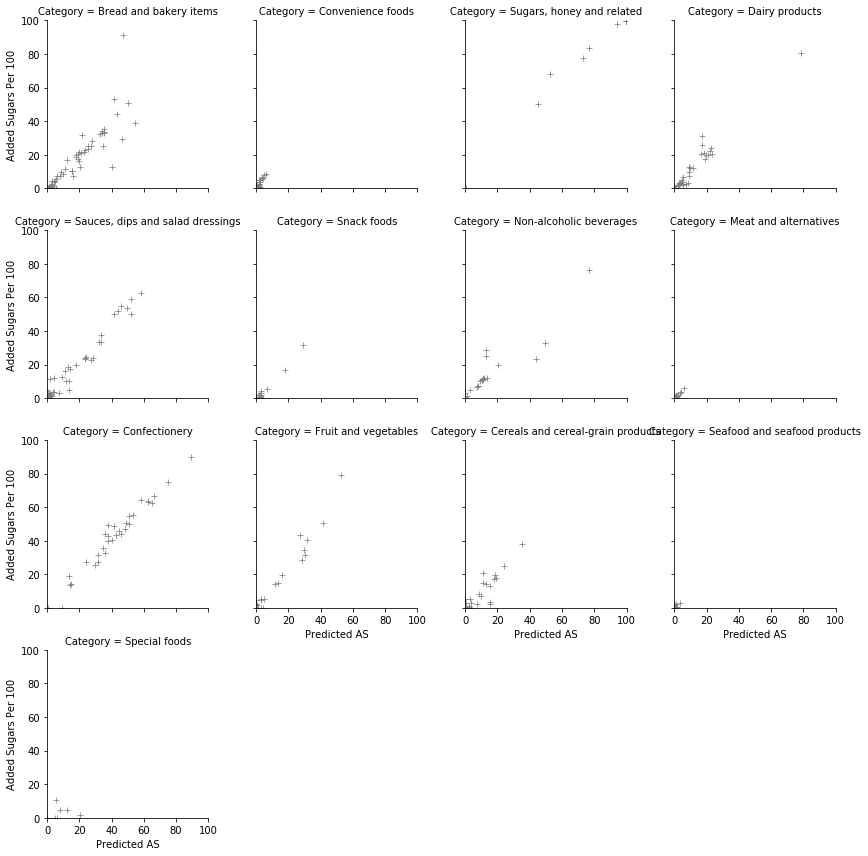

In [27]:
# Scatter plots for each category
test['Category'] = test['Major category']
f = sns.FacetGrid(test, col = 'Category', col_wrap = 4, ylim = (0, 100), xlim = (0, 100))
f.map(sns.scatterplot, "Predicted AS", "Added Sugars Per 100", marker = '+', color = 'grey')
f.savefig('AS cat plot.png', dpi = 500)

In [28]:
# Confusion matrix
data4 = []
for group in ['Low', 'Medium', 'High']:
    row = test[test['True AS class'] == group]['Predicted AS class'].value_counts().to_dict()
    data4.append(row)
    
KNN_matrix = pd.DataFrame(data4)
KNN_matrix.index = ['Low', 'Medium', 'High']
KNN_matrix[['Low', 'Medium', 'High']]
# Rows are the true class, columns are the predicted class

,Low,Medium,High
Low,265.0,23,2
Medium,14.0,53,8
High,NaN,7,128


In [29]:
print(classification_report(test['True AS class'], test['Predicted AS class']))

              precision    recall  f1-score   support

        High       0.93      0.95      0.94       135
         Low       0.95      0.91      0.93       290
      Medium       0.64      0.71      0.67        75

    accuracy                           0.89       500
   macro avg       0.84      0.86      0.85       500
weighted avg       0.90      0.89      0.89       500



# 9. Benchmarking against baseline and JL method

In [30]:
# Determine added sugar proportions for each training product
train['AS prop'] = train['Added Sugars Per 100']/train['Total Sugars Per 100']

# Determine mean added sugar proportion for each KNN category (exclude products w/o AS ingredients)
category_means = pd.DataFrame()
category_means['KNN category'] = [x.lower() for x in train[train['AS ingredient'] == 1].groupby('KNN category')['AS prop'].mean().index.tolist()]
category_means['Mean AS Prop'] = train[train['AS ingredient'] == 1].groupby('KNN category')['AS prop'].mean().tolist()

# Merge mean proportions onto testing dataset
test = test.merge(category_means, how = 'left', on = 'KNN category')

# Apply baseline (blanket proportioning)


test['Baseline prediction'] = np.where(test['AS ingredient'] == 1, test['Mean AS Prop']*test['Total Sugars Per 100'], 0)
test['Baseline prediction'] = np.where(test['Baseline prediction'] > test['Total Sugars Per 100'], test['Total Sugars Per 100'], test['Baseline prediction'])
test['Baseline AS class'] = (test['Food/drink'] + ' ' + test['Baseline prediction'].astype(str)).apply(high_medium_low)


# Print performance metrics for the baseline
print('R2:', np.round(r2_score(test['Baseline prediction'], test['Added Sugars Per 100']), 2))
print('MAE:', np.round(mean_absolute_error(test['Baseline prediction'], test['Added Sugars Per 100']), 2))
print('SRC:', np.round(spearman_correlation(test['Baseline prediction'], test['Added Sugars Per 100']), 2))
print('CA:', np.round(accuracy_score(test['Baseline AS class'], test['True AS class']), 2))

R2: 0.86
MAE: 2.26
SRC: 0.92
CA: 0.9


In [31]:
# Benchmarking against gold standard - Jimmy Louie method
test = test.merge(JL, how = 'left', on = 'Product Id')

test['JL AS class'] = (test['Food/drink'] + ' ' + test['JLAS_g'].astype(str)).apply(high_medium_low)
print('R2:', np.round(r2_score(test['JLAS_g'], test['Added Sugars Per 100']), 2))
print('MAE:', np.round(mean_absolute_error(test['JLAS_g'], test['Added Sugars Per 100']), 2))
print('SRC:', np.round(spearman_correlation(test['JLAS_g'], test['Added Sugars Per 100']), 2))
print('CA:', np.round(accuracy_score(test['JL AS class'], test['True AS class']), 2))

R2: 0.97
MAE: 1.26
SRC: 0.93
CA: 0.9


# 10. Retrieve neighbours for predictions in test dataset

In [32]:
# Create an empty dataframe. Vertically concatenate product + neighbours to this dataframe
big = pd.DataFrame()

# Loop through each product in the testing dataset
for i in range(0, 500):
    # Access the eight nearest neighbours for each testing product
    neighbours =  model.kneighbors([test_prep[test_prep.columns[0:-2]].iloc[i].as_matrix()])
    
    # Access the indexes of these neighbours:
    indexes = neighbours[1][0]
    
    # Access the distances between these neighbours and the query product
    distances = neighbours[0][0]
    
    # Acess product data for the query product    
    query_data = test[test.index == i]
   
    # Acess product data for the neighbours
    n1 = train[train.index == indexes[0]]
    n2 = train[train.index == indexes[1]]
    n3 = train[train.index == indexes[2]]
    n4 = train[train.index == indexes[3]]
    n5 = train[train.index == indexes[4]]
    n6 = train[train.index == indexes[5]]
    n7 = train[train.index == indexes[6]]
    n8 = train[train.index == indexes[7]]   
    neighbours_data = pd.concat([n1, n2, n3, n4, n5, n6, n7, n8])
    neighbours_data['d'] = distances
    
    # Vertically concatenate product and neighbours data
    combine_data = pd.concat([query_data, neighbours_data])
    
    # Vertically concatenate this dataframe onto the big dataframe
    big = pd.concat([big, combine_data])


    
big['MAE'] = np.abs(big['Predicted AS'] - big['Added Sugars Per 100']).ffill()
big['Original order'] = range(0, big.shape[0])
big.sort_values(by = ['MAE', 'Original order'], ascending = [False, True], inplace=True)
big.reset_index(drop=True, inplace=True)

# select required columns
big = big[[ 'Major category','KNN category','Food/drink',
    'Product Id', 'UPC','Product Name','Description','Brand', 'Ingredients',
     'Protein Per 100', 'Saturated Fat Per 100', 'Sodium Per 100',
       'Unsaturated Fat Per 100', 'Total Sugars Per 100', 'Starch Per 100',     
    'AS ingredient', 
         'Predicted AS class',
     'True AS class', 'Added Sugars Per 100','d', 'Baseline prediction',         
        'JLAS_g', 
       'Predicted AS', 'MAE']]

In [33]:
# check out neighbours for "Mainland Cracker Cuts Tasy product"
big.tail(9)

,Major category,KNN category,Food/drink,Product Id,UPC,Product Name,Description,Brand,Ingredients,Protein Per 100,Saturated Fat Per 100,Sodium Per 100,Unsaturated Fat Per 100,Total Sugars Per 100,Starch Per 100,AS ingredient,Predicted AS class,True AS class,Added Sugars Per 100,d,Baseline prediction,JLAS_g,Predicted AS,MAE
4491,Dairy products,cheese,Food,66930.0,NaN,Mainland Cracker Cuts Tasty,NaN,NaN,Milk | Salt | Cultures | Enzyme (Rennet),3.339016,2.150719,708.000015,1.188297,5.892382,0.0,0,Low,Low,0.0,NaN,0.0,0.0,0.0,0.0
4492,Dairy products,Cheese,NaN,NaN,85239260302,NaN,MEDIUM SALSA CON QUESO DIP MADE WITH CHEDDAR C...,ARCHER FARMS,"WATER, NONFAT MILK, MONTEREY JACK CHEESE (CULT...",3.200000,3.200000,645.200000,4.900000,3.200000,3.2,0,NaN,NaN,0.0,0.135672,NaN,NaN,NaN,0.0
4493,Dairy products,Cheese,NaN,NaN,193476002620,NaN,1% LOW FAT SMALL CURD COTTAGE CHEESE,THAT'S SMART!,"PASTEURIZED CULTURED SKIM MILK, CREAM, SALT, G...",7.100000,0.900000,354.000000,0.000000,3.500000,0.9,0,NaN,NaN,0.0,0.138305,NaN,NaN,NaN,0.0
4494,Dairy products,Cheese,NaN,NaN,7.87421e+10,NaN,RICOTTA CHEESE,GREAT VALUE,"WHEY, MILK, VINEGAR, XANTHAN GUM, LOCUST BEAN ...",8.100000,4.000000,88.700000,2.400000,6.400000,0.0,0,NaN,NaN,0.0,0.145633,NaN,NaN,NaN,0.0
4495,Dairy products,Cheese,NaN,NaN,70038647058,NaN,RICOTTA CHEESE,BEST CHOICE,"PASTEURIZED WHEY, PASTEURIZED CREAM, PASTEURIZ...",7.300000,2.700000,90.900000,2.700000,7.300000,1.8,0,NaN,NaN,0.0,0.146799,NaN,NaN,NaN,0.0
4496,Dairy products,Cheese,NaN,NaN,070896002545,NaN,COTTAGE CHEESE,NORDICA,"INGREDIENTS: CULTURED PASTEURIZED SKIM MILK, M...",10.600000,3.100000,424.800000,1.300000,3.500000,0.0,0,NaN,NaN,0.0,0.152664,NaN,NaN,NaN,0.0
4497,Dairy products,Cheese,NaN,NaN,049900342643,NaN,4% SMALL CURD COTTAGE CHEESE,KNUDSEN,INGREDIENTS: CULTURED PASTEURIZED GRADE A NONF...,9.300000,2.500000,330.500000,1.700000,3.400000,1.7,0,NaN,NaN,0.0,0.155152,NaN,NaN,NaN,0.0
4498,Dairy products,Cheese,NaN,NaN,049900001632,NaN,4% SMALL CURD COTTAGE CHEESE,KNUDSEN,INGREDIENTS: CULTURED PASTEURIZED GRADE A NONF...,9.300000,2.500000,330.500000,1.700000,3.400000,1.7,0,NaN,NaN,0.0,0.155152,NaN,NaN,NaN,0.0
4499,Dairy products,Cheese,NaN,NaN,193968049867,NaN,SMALL CURD LOW FAT COTTAGE CHEESE,MEMBER'S MARK,"CULTURED PASTEURIZED SKIM MILK, MILK, CREAM, D...",11.500000,1.300000,442.500000,0.900000,4.400000,0.0,0,NaN,NaN,0.0,0.155921,NaN,NaN,NaN,0.0


# 11. Performance by first neighour distance

In [34]:
# Some adjustments to the above dataframe to determine this
big['Predicted AS'] = big['Predicted AS'].ffill()
big['Query AS'] = np.where(big['d'].isnull(), big['Added Sugars Per 100'], np.NaN)
big['Query AS'] = big['Query AS'].ffill()

big['True AS class'] = big['True AS class'].ffill()
big['Predicted AS class'] = big['Predicted AS class'].ffill()

first_neighbours = big[big.index % 9 == 1]

In [35]:
# determine first neighbours distance quartiles
q1 = np.percentile(first_neighbours['d'], 25)
q2 = np.percentile(first_neighbours['d'], 50)
q3 = np.percentile(first_neighbours['d'], 75)

# Divide test products into four groups based on quartiles
group_1 = first_neighbours[(first_neighbours['d'] < q1)]
group_2 = first_neighbours[(first_neighbours['d'] >= q1) & (first_neighbours['d'] < q2)]
group_3 = first_neighbours[(first_neighbours['d'] >= q2) & (first_neighbours['d'] < q3)]
group_4 = first_neighbours[(first_neighbours['d'] >= q3)]

# Determine performance metrics for each group
data10 = []

for group in [group_1, group_2, group_3, group_4]:
    row = {}
    row['n'] = group.shape[0]
    row['R2'] = np.round(r2_score(group['Query AS'], group['Predicted AS']), 2)
    row['MAE'] = np.round(mean_absolute_error(group['Query AS'], group['Predicted AS']), 2)
    row['SRC'] = np.round(spearman_correlation(group['Query AS'], group['Predicted AS']), 2)     
    row['CA'] = np.round(accuracy_score(group['True AS class'], group['Predicted AS class']), 2)
    data10.append(row) 

by_distance = pd.DataFrame(data10)
by_distance

,CA,MAE,R2,SRC,n
0,0.94,0.90,0.98,0.97,125
1,0.86,1.37,0.98,0.93,125
2,0.92,1.71,0.94,0.93,125
3,0.84,3.47,0.89,0.87,125


# 12. Performance by training dataset size

In [36]:
data11 = []
for size in [4000, 8000, 12000, 16000,  20000,
            24000, 28000,  32000,  36000,  40000,
            44000]:
    train_subset = train_prep.head(size)
    X3 = train_subset[train_subset.columns[:-2]].reset_index(drop=True)    
    y3 = train_subset[train_subset.columns[-1]].reset_index(drop=True)
    
    model3 = KNN.fit(X3, y3)
    pred = model.predict(test_prep[test_prep.columns[:-2]])
    total_sugar = test_prep['Total Sugars Per 100']*100
    pred = np.where(pred>total_sugar, total_sugar, pred)  
        
        
    true = test_prep[test_prep.columns[-1]]
    
    row = {}
    row['n']= size         
    row['R2'] = np.round(r2_score(true, pred), 2)
    row['MAE'] = np.round(mean_absolute_error(true, pred), 2)
    row['SRC'] = np.round(spearman_correlation(true, pred), 2)
    pred_class = (test['Food/drink'] + ' ' + pred.astype(str)).apply(high_medium_low)    
    row['CA'] = np.round(accuracy_score(test['True AS class'], pred_class), 2)
    data11.append(row)
    
learning = pd.DataFrame(data11)
learning

,CA,MAE,R2,SRC,n
0,0.87,2.22,0.93,0.90,4000
1,0.88,2.05,0.93,0.91,8000
2,0.88,1.97,0.94,0.92,12000
3,0.89,2.05,0.93,0.92,16000
4,0.89,2.03,0.93,0.92,20000
5,0.89,1.90,0.95,0.92,24000
6,0.90,1.91,0.95,0.92,28000
7,0.90,1.89,0.95,0.92,32000
8,0.89,1.86,0.95,0.91,36000
9,0.89,1.87,0.95,0.92,40000
